In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import scipy.stats as stats

import seaborn as sns
import wrangle, scale

### Aquire/Prepare

In [2]:
zillow_df = wrangle.get_all_zillow_data()

/opt/homebrew/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3357: DtypeWarning: Columns (63) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


In [3]:
zillow_df.head(2)

,typeconstructiontypeid,storytypeid,propertylandusetypeid,heatingorsystemtypeid,buildingclasstypeid,architecturalstyletypeid,airconditioningtypeid,parcelid,id,basementsqft,...,censustractandblock,logerror,transactiondate,airconditioningdesc,architecturalstyledesc,buildingclassdesc,heatingorsystemdesc,propertylandusedesc,storydesc,typeconstructiondesc
0,NaN,NaN,261.0,NaN,NaN,NaN,NaN,14297519,1727539,NaN,...,6.059063e+13,0.025595,2017-01-01,NaN,NaN,NaN,NaN,Single Family Residential,NaN,NaN
1,NaN,NaN,261.0,NaN,NaN,NaN,NaN,17052889,1387261,NaN,...,6.111001e+13,0.055619,2017-01-01,NaN,NaN,NaN,NaN,Single Family Residential,NaN,NaN


In [4]:
for i in zillow_df:
    if i == 'bedroomcnt' or i =='bathroomcnt':
        zillow_df = wrangle.handle_outliers(zillow_df, i, .10, .75)


#drop column if its missing 50% or more of its rows
zillow_df = wrangle.drop_nulls(zillow_df, 1, 50)
#drop row if its missing 20% or more of its columns
zillow_df = wrangle.drop_nulls(zillow_df,0, 20)
#drop remaining rows
zillow_df = zillow_df.dropna()


<class 'pandas.core.series.Series'>


In [5]:
train, validate, test = wrangle.split_for_model(zillow_df)

train(24279, 34),validate(10406, 34),test(8672, 34)


### Explore 
 - Target = logerror

In [6]:
# Distributions 

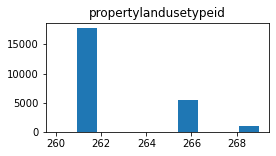

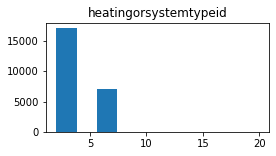

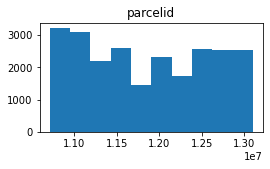

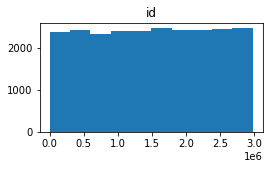

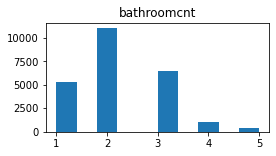

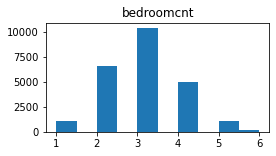

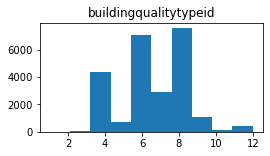

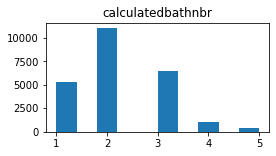

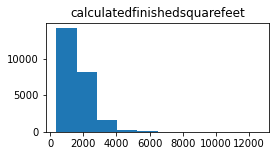

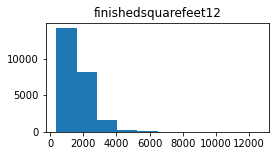

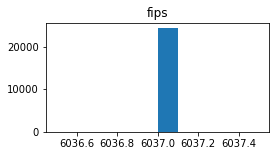

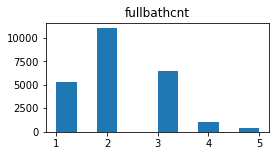

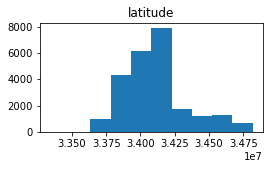

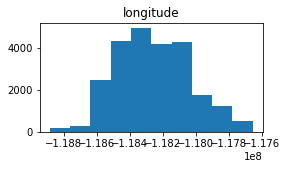

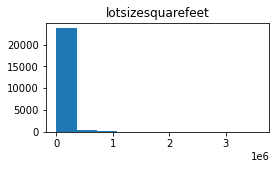

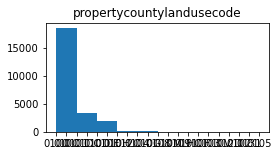

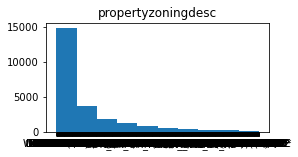

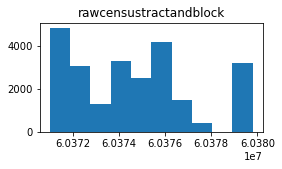

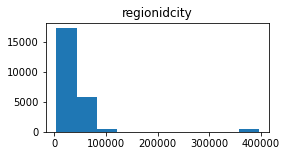

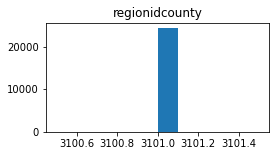

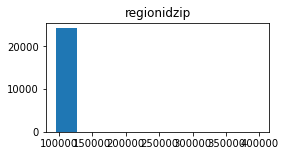

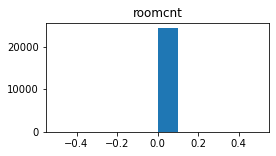

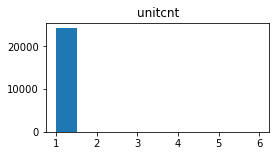

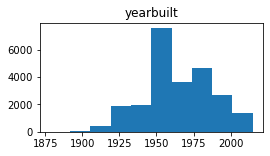

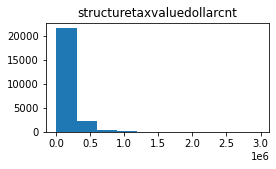

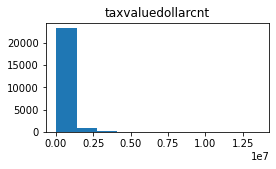

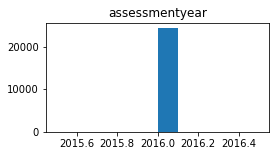

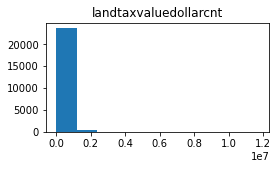

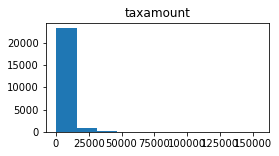

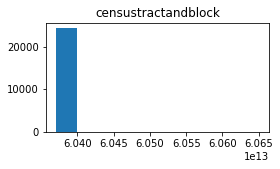

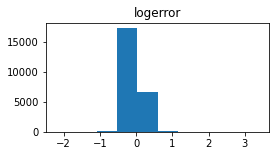

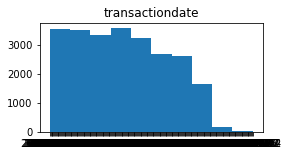

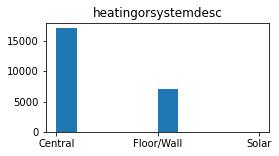

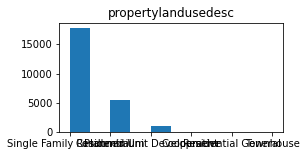

In [7]:
for col in train.columns:
    plt.figure(figsize=(4,2))
    plt.hist(train[col])
    plt.title(col)
    plt.show()

In [55]:
#1. logerror in relation pricing
# Bin house prices into, 10 bins for, roughly every 100,000 dollars
train['pricing_bins'] = pd.cut(train.taxvaluedollarcnt, bins=10)

In [56]:
train.pricing_bins.value_counts()

(-234.746, 1372026.6]       23364
(1372026.6, 2730701.2]        747
(2730701.2, 4089375.8]        116
(4089375.8, 5448050.4]         25
(5448050.4, 6806725.0]         16
(8165399.6, 9524074.2]          4
(6806725.0, 8165399.6]          3
(9524074.2, 10882748.8]         3
(12241423.4, 13600098.0]        1
(10882748.8, 12241423.4]        0
Name: pricing_bins, dtype: int64

<AxesSubplot:xlabel='logerror', ylabel='pricing_bins'>

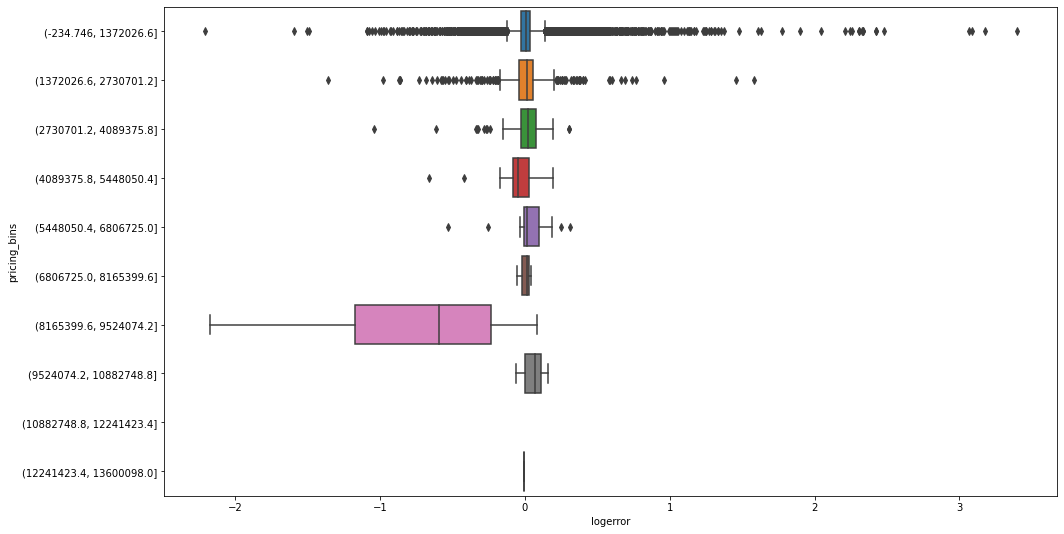

In [57]:
plt.figure(figsize=(16,9))
sns.boxplot(data=train, x='logerror', y ='pricing_bins')

In [58]:
#h0 Pricing of the house has no effect on logerror
stats.levene(train.logerror, train.taxvaluedollarcnt)

LeveneResult(statistic=8435.522746208986, pvalue=0.0)

In [59]:
stats.ttest_ind(train.logerror, train.taxvaluedollarcnt, equal_var=True)

Ttest_indResult(statistic=-136.6753553579141, pvalue=0.0)

In [60]:
#2 year built in relation to log error
train['year_bins'] = pd.cut(train.yearbuilt, bins=10)

<AxesSubplot:xlabel='logerror', ylabel='year_bins'>

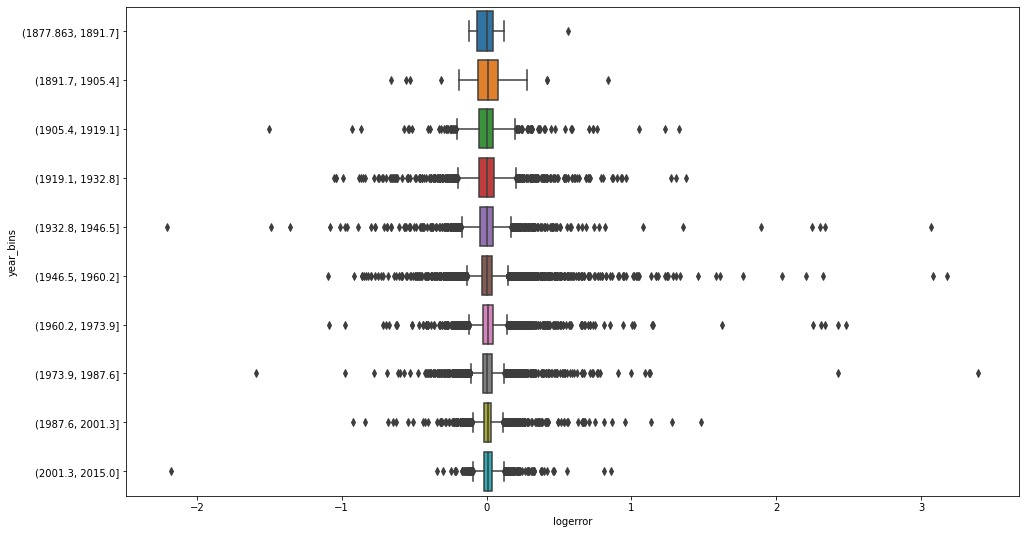

In [61]:
plt.figure(figsize=(16,9))
sns.boxplot(data=train, x='logerror', y ='year_bins')

In [62]:
#h0 Year built has no effect on logerror
stats.levene(train.logerror, train.yearbuilt)

LeveneResult(statistic=47922.946475271805, pvalue=0.0)

In [63]:
stats.ttest_ind(train.logerror, train.yearbuilt, equal_var=True)

Ttest_indResult(statistic=-13482.46974238744, pvalue=0.0)

In [64]:
#reject null hypothesis

In [65]:
#3 see if log error varies for houses before and after 1932
stats.ttest_ind(train[train.yearbuilt < 1932].yearbuilt, train[train.yearbuilt >= 1932].yearbuilt, equal_var=True)

Ttest_indResult(statistic=-118.35437971101331, pvalue=0.0)

In [66]:
#4 month the house was sold in relation to log error
train['transactiondate'] = pd.to_datetime(train['transactiondate'],dayfirst=True)

In [67]:
train['transactionmonth'] =  train['transactiondate'].dt.month

In [68]:
train.transactionmonth.value_counts()

6    3546
5    3186
8    3074
3    3000
7    2953
4    2680
1    2197
2    2011
9    1632
Name: transactionmonth, dtype: int64

<AxesSubplot:xlabel='transactionmonth', ylabel='logerror'>

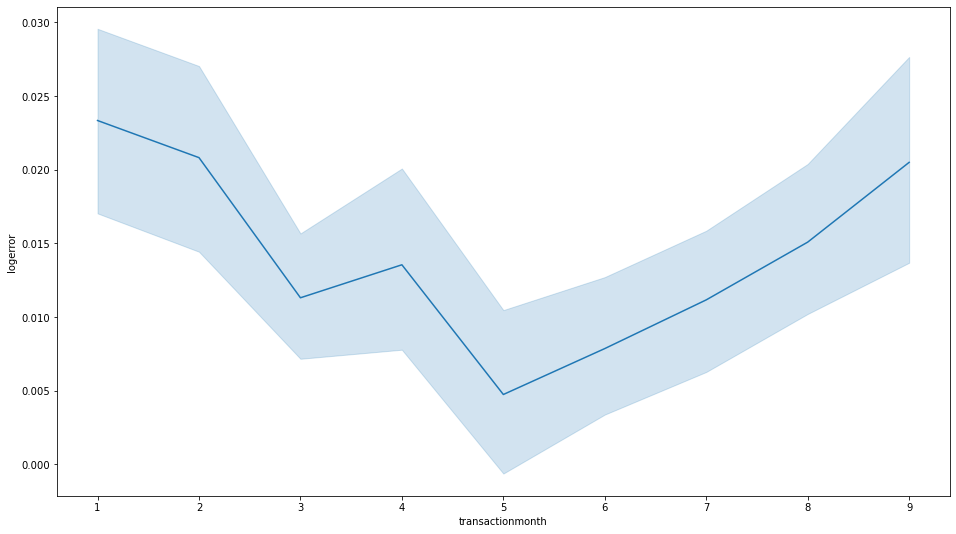

In [77]:
plt.figure(figsize=(16,9))
sns.lineplot(data=train, y='logerror', x ='transactionmonth')
#looks like log error accuracy peaks in may, even though the numbbers of houses is distibuted uniformly

In [70]:
#equal variance